In [ ]:
# -*- coding: utf-8 -*-
"""Hand Movement Phase + Health Status Level Prediction System"""

# Install required packages
!pip install tensorflow scikit-learn seaborn pandas numpy matplotlib joblib imbalanced-learn -q

# Import libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

import warnings
import joblib
import os
import gc
import shutil
from collections import Counter
from datetime import datetime
import json

warnings.filterwarnings('ignore')

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("✅ Libraries imported successfully")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Libraries imported successfully


In [ ]:
class HealthStatusDataAugmenter:
    """Create synthetic H1, H2, H3 samples from H samples for training"""

    def __init__(self, noise_levels={'H1': 0.1, 'H2': 0.3, 'H3': 0.5}):
        self.noise_levels = noise_levels
        self.status_distribution = {'H': 0.4, 'H1': 0.2, 'H2': 0.2, 'H3': 0.2}

    def augment_data(self, sequences, y_phase, y_status, phase_encoder, status_encoder):
        """Augment data by creating synthetic H1, H2, H3 samples"""

        # Decode current status
        current_status = status_encoder.inverse_transform(np.argmax(y_status, axis=1))

        print(f"\n🔍 Current status distribution:")
        status_counts = Counter(current_status)
        for status, count in status_counts.items():
            print(f"   {status}: {count} samples ({count/len(current_status)*100:.1f}%)")

        # If we only have 'H', create synthetic samples
        if len(status_counts) == 1 and 'H' in status_counts:
            print("\n⚠️ Only 'H' samples found. Creating synthetic H1, H2, H3 samples...")

            # Get indices of H samples
            h_indices = np.where(current_status == 'H')[0]

            # Determine how many samples to create for each class
            total_samples = len(sequences)
            target_counts = {
                'H': int(self.status_distribution['H'] * total_samples),
                'H1': int(self.status_distribution['H1'] * total_samples),
                'H2': int(self.status_distribution['H2'] * total_samples),
                'H3': int(self.status_distribution['H3'] * total_samples)
            }

            # Ensure we have enough H samples
            target_counts['H'] = min(target_counts['H'], len(h_indices))

            # Create augmented sequences and labels
            augmented_sequences = []
            augmented_phases = []
            augmented_statuses = []

            # 1. Keep some original H samples
            h_selected = np.random.choice(h_indices, target_counts['H'], replace=False)

            for idx in h_selected:
                augmented_sequences.append(sequences[idx])
                augmented_phases.append(y_phase[idx])
                augmented_statuses.append(y_status[idx])

            # 2. Create synthetic H1, H2, H3 samples by adding noise to H samples
            remaining_h_indices = [i for i in h_indices if i not in h_selected]

            for status_class in ['H1', 'H2', 'H3']:
                noise_level = self.noise_levels[status_class]
                n_needed = target_counts[status_class]

                # Select H samples to augment
                if len(remaining_h_indices) < n_needed:
                    # If not enough unique samples, allow reuse
                    selected_idx = np.random.choice(remaining_h_indices, n_needed, replace=True)
                else:
                    selected_idx = np.random.choice(remaining_h_indices, n_needed, replace=False)

                for idx in selected_idx:
                    # Add noise based on severity level
                    noisy_sequence = self.add_noise_to_sequence(
                        sequences[idx],
                        noise_level=noise_level,
                        status_class=status_class
                    )

                    augmented_sequences.append(noisy_sequence)
                    augmented_phases.append(y_phase[idx])

                    # Create new status label
                    status_label = np.zeros_like(y_status[0])
                    status_idx = status_encoder.transform([status_class])[0]
                    status_label[status_idx] = 1
                    augmented_statuses.append(status_label)

            # Convert to arrays
            augmented_sequences = np.array(augmented_sequences)
            augmented_phases = np.array(augmented_phases)
            augmented_statuses = np.array(augmented_statuses)

            print(f"\n✅ Created augmented dataset:")
            print(f"   Original size: {len(sequences)} sequences")
            print(f"   Augmented size: {len(augmented_sequences)} sequences")

            # Check distribution
            aug_status_decoded = status_encoder.inverse_transform(np.argmax(augmented_statuses, axis=1))
            aug_counts = Counter(aug_status_decoded)
            for status in ['H', 'H1', 'H2', 'H3']:
                count = aug_counts.get(status, 0)
                print(f"   {status}: {count} samples ({count/len(augmented_sequences)*100:.1f}%)")

            return augmented_sequences, augmented_phases, augmented_statuses

        else:
            print("✅ Multiple status classes already present")
            return sequences, y_phase, y_status

    def add_noise_to_sequence(self, sequence, noise_level, status_class):
        """Add realistic noise to simulate different health status levels"""

        noisy_sequence = sequence.copy()

        # Different noise patterns for different status levels
        if status_class == 'H1':
            # Mild noise: small random variations
            noise = np.random.normal(0, noise_level * 0.1, sequence.shape)
            noisy_sequence += noise

        elif status_class == 'H2':
            # Moderate noise: larger variations with some pattern
            noise = np.random.normal(0, noise_level * 0.2, sequence.shape)
            # Add some temporal correlation
            for i in range(1, len(noisy_sequence)):
                noisy_sequence[i] += 0.3 * noisy_sequence[i-1] * noise_level
            noisy_sequence += noise

        elif status_class == 'H3':
            # Severe noise: large variations with irregular patterns
            noise = np.random.normal(0, noise_level * 0.3, sequence.shape)
            # Add spikes
            spike_indices = np.random.choice(len(noisy_sequence),
                                           size=int(0.1 * len(noisy_sequence)),
                                           replace=False)
            for idx in spike_indices:
                noisy_sequence[idx] += noise_level * np.random.randn(*noisy_sequence[idx].shape)
            noisy_sequence += noise

        return noisy_sequence

In [ ]:
class HealthStatusDataLoader:
    """Data loader for both phase and status prediction with demographics"""

    def __init__(self, sequence_length=20, step_size=5):
        self.sequence_length = sequence_length
        self.step_size = step_size
        self.phase_encoder = LabelEncoder()
        self.status_encoder = LabelEncoder()  # For H, H1, H2, H3
        self.scaler = RobustScaler()

        # Define classes
        self.phase_types = ['START', 'MID', 'END', 'STEADY']
        self.status_types = ['H', 'H1', 'H2', 'H3']  # Health status levels

        # Demographic preprocessing
        self.age_scaler = StandardScaler()
        self.gender_encoder = LabelEncoder()
        self.hand_encoder = LabelEncoder()

    def load_and_process(self, file_path):
        """Load data and create phase + health status labels with demographics"""
        print(f"📂 Loading: {file_path}")

        # Load data
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except:
            try:
                df = pd.read_csv(file_path, encoding='latin-1')
            except:
                df = pd.read_csv(file_path, encoding='ISO-8859-1')

        print(f"📊 Dataset shape: {df.shape}")
        print(f"Columns: {list(df.columns)}")

        # Check for required columns
        required_cols = ['Age', 'Gender', 'Hand', 'Movement']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            print(f"⚠️ Missing columns: {missing_cols}")
            print("Creating placeholder demographic columns...")

            # Add missing columns with default values
            if 'Age' not in df.columns:
                df['Age'] = 10  # Default age
            if 'Gender' not in df.columns:
                df['Gender'] = 'M'  # Default gender
            if 'Hand' not in df.columns:
                df['Hand'] = 'R'  # Default hand

        # Create phase labels
        df_with_phases = self._create_phase_labels(df)

        # Check if Status column exists
        df_with_phases = self._create_health_status_labels(df_with_phases)

        # Convert status to standard format (H, H1, H2, H3)
        df_with_phases['Status'] = self._standardize_status_labels(df_with_phases['Status'])

        # Extract features with demographics
        X, y_phase, y_status, feature_names, demo_features = self._extract_features_with_demographics(df_with_phases)

        # Create sequences
        sequences, phase_labels, status_labels = self._create_sequences(X, y_phase, y_status)

        # Encode labels
        y_phase_encoded = self.phase_encoder.fit_transform(phase_labels)
        y_status_encoded = self.status_encoder.fit_transform(status_labels)

        # Convert to categorical
        y_phase_cat = keras.utils.to_categorical(y_phase_encoded)
        y_status_cat = keras.utils.to_categorical(y_status_encoded)

        print(f"✅ Phase classes: {list(self.phase_encoder.classes_)}")
        print(f"✅ Status classes: {list(self.status_encoder.classes_)}")
        print(f"✅ Sequence shape: {sequences.shape}")

        return sequences, y_phase_cat, y_status_cat, feature_names, demo_features

    def _create_phase_labels(self, df):
        """Create START, MID, END, STEADY labels"""
        df_processed = df.copy()
        df_processed['phase'] = 'STEADY'  # Default to STEADY

        # Identify dynamic movements
        dynamic_movements = ['FLEXION', 'EXTENSION', 'ADDUCTION', 'ABDUCTION', 'CIRCUMDUCTION']

        for movement in df_processed['Movement'].unique():
            if movement in dynamic_movements:
                movement_mask = df_processed['Movement'] == movement
                movement_indices = np.where(movement_mask)[0]

                if len(movement_indices) > 10:  # Enough samples for phases
                    # Sort by timestamp if available
                    if 'Timestamp' in df_processed.columns:
                        movement_df = df_processed.loc[movement_mask].copy()
                        movement_df = movement_df.sort_values('Timestamp')
                        movement_indices = movement_df.index

                    # Assign phases based on progression
                    for i, idx in enumerate(movement_indices):
                        progress = i / len(movement_indices)
                        if progress < 0.33:
                            df_processed.loc[idx, 'phase'] = 'START'
                        elif progress < 0.67:
                            df_processed.loc[idx, 'phase'] = 'MID'
                        else:
                            df_processed.loc[idx, 'phase'] = 'END'

        print(f"📊 Phase distribution: {df_processed['phase'].value_counts().to_dict()}")
        return df_processed

    def _create_health_status_labels(self, df):
        """Create health status labels based on existing Status column"""
        df_processed = df.copy()

        # Check if Status column exists and has data
        if 'Status' in df_processed.columns and df_processed['Status'].notna().any():
            print(f"✅ Using existing Status column: {Counter(df_processed['Status'])}")
            return df_processed

        print("⚠️ Status column not found or empty. Creating health status labels...")

        # Create health status labels based on movement quality
        # In real scenario, these would come from clinical assessments

        # First, standardize any existing status values
        if 'Status' in df_processed.columns:
            df_processed['Status'] = self._standardize_status_labels(df_processed['Status'])

        # If still no status, create sample distribution
        if df_processed['Status'].isna().all() or len(df_processed['Status'].unique()) == 0:
            n_samples = len(df_processed)
            np.random.seed(42)

            # Create distribution (60% H, 15% H1, 15% H2, 10% H3)
            status_dist = ['H'] * int(0.6 * n_samples) + \
                          ['H1'] * int(0.15 * n_samples) + \
                          ['H2'] * int(0.15 * n_samples) + \
                          ['H3'] * int(0.1 * n_samples)

            # Add remaining to maintain length
            while len(status_dist) < n_samples:
                status_dist.append('H')

            np.random.shuffle(status_dist)
            df_processed['Status'] = status_dist[:n_samples]

        print(f"📊 Created health status distribution: {Counter(df_processed['Status'])}")
        return df_processed

    def _standardize_status_labels(self, status_series):
        """Convert status labels to standard H, H1, H2, H3 format"""
        # Convert to string and uppercase
        status_series = status_series.astype(str).str.upper().str.strip()

        # Create mapping for common variations
        status_map = {
            # Healthy variations
            'H': 'H', 'HEALTHY': 'H', 'NORMAL': 'H', 'GOOD': 'H', '0': 'H',
            # Mild variations
            'H1': 'H1', 'MILD': 'H1', '1': 'H1',
            # Moderate variations
            'H2': 'H2', 'MODERATE': 'H2', '2': 'H2',
            # Severe variations
            'H3': 'H3', 'SEVERE': 'H3', '3': 'H3'
        }

        # Apply mapping, default to H if not found
        return status_series.map(lambda x: status_map.get(x, 'H'))

    def _extract_features_with_demographics(self, df):
        """Extract sensor features and demographic information"""

        # 1. Identify sensor features
        sensor_cols = []
        for col in df.columns:
            col_lower = col.lower()
            if ('angle' in col_lower or 'accel' in col_lower or
                'gyro' in col_lower or 'thumb' in col_lower or
                'index' in col_lower or 'middle' in col_lower or
                'ring' in col_lower or 'pinky' in col_lower or
                col in ['AbductionAngle', 'RotationAngle', 'MovementMagnitude']):
                if col not in ['Movement', 'Status', 'phase', 'Gender', 'Age', 'Hand', 'Timestamp']:
                    sensor_cols.append(col)

        print(f"✅ Found {len(sensor_cols)} sensor features")

        # 2. Extract sensor data
        if sensor_cols:
            X_sensor = df[sensor_cols].values
            X_sensor_scaled = self.scaler.fit_transform(X_sensor)
        else:
            X_sensor_scaled = np.zeros((len(df), 1))

        # 3. Extract demographic data
        demo_features = []

        # Age (normalize)
        if 'Age' in df.columns:
            age_normalized = (df['Age'] - df['Age'].mean()) / df['Age'].std()
            demo_features.append(age_normalized.values.reshape(-1, 1))
            print(f"✅ Age normalized: mean={df['Age'].mean():.1f}, std={df['Age'].std():.1f}")

        # Gender (encode)
        if 'Gender' in df.columns:
            # Clean gender labels
            gender_mapping = {'M': 0, 'Male': 0, 'F': 1, 'Female': 1}
            gender_encoded = df['Gender'].map(gender_mapping).fillna(0)
            demo_features.append(gender_encoded.values.reshape(-1, 1))
            print(f"✅ Gender encoded: {Counter(gender_encoded.values)}")

        # Hand (encode)
        if 'Hand' in df.columns:
            # Clean hand labels
            hand_mapping = {'R': 0, 'Right': 0, 'L': 1, 'Left': 1}
            hand_encoded = df['Hand'].map(hand_mapping).fillna(0)
            demo_features.append(hand_encoded.values.reshape(-1, 1))
            print(f"✅ Hand encoded: {Counter(hand_encoded.values)}")

        # Combine demographic features
        if demo_features:
            X_demo = np.hstack(demo_features)
        else:
            X_demo = np.zeros((len(df), 3))  # Default 3 demographic features

        # 4. Movement type (one-hot encoded)
        movement_dummies = pd.get_dummies(df['Movement'], prefix='movement')
        X_movement = movement_dummies.values
        print(f"✅ Movement types: {list(movement_dummies.columns)}")

        # 5. Combine all features
        X_combined = np.hstack([X_sensor_scaled, X_demo, X_movement])

        print(f"✅ Total features: {X_combined.shape[1]} "
              f"(Sensors: {X_sensor_scaled.shape[1]}, "
              f"Demographics: {X_demo.shape[1]}, "
              f"Movement: {X_movement.shape[1]})")

        # 6. Extract labels
        y_phase = df['phase'].values
        y_status = df['Status'].values

        print(f"✅ Phase distribution: {Counter(y_phase)}")
        print(f"✅ Status distribution: {Counter(y_status)}")

        # 7. Feature names for interpretation
        feature_names = sensor_cols + ['Age', 'Gender', 'Hand'] + list(movement_dummies.columns)

        return X_combined, y_phase, y_status, feature_names, X_demo

    def _create_sequences(self, X, y_phase, y_status):
        """Create time sequences from data with phase and status labels"""
        sequences = []
        phase_labels = []
        status_labels = []

        for i in range(0, len(X) - self.sequence_length, self.step_size):
            sequences.append(X[i:i + self.sequence_length])

            # Use the middle point label for stability
            mid_idx = i + self.sequence_length // 2
            if mid_idx < len(y_phase):
                phase_labels.append(y_phase[mid_idx])
                status_labels.append(y_status[mid_idx])

        sequences = np.array(sequences)

        print(f"✅ Created {len(sequences)} sequences")
        print(f"✅ Sequence shape: {sequences.shape}")

        return sequences, phase_labels, status_labels

In [ ]:
def create_phase_status_model(input_shape, num_phases, num_statuses):
    """Create multi-output model for phase and status prediction"""

    inputs = keras.Input(shape=input_shape)

    # Shared LSTM layers
    x = layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)(inputs)
    x = layers.BatchNormalization()(x)

    x = layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.1)(x)
    x = layers.BatchNormalization()(x)

    x = layers.LSTM(32, dropout=0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Shared dense layers
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0005))(x)

    # Phase output branch
    phase_branch = layers.Dense(16, activation='relu')(x)
    phase_output = layers.Dense(num_phases, activation='softmax', name='phase')(phase_branch)

    # Status output branch - uses phase information
    # Combine shared features with phase probabilities
    status_branch = layers.Concatenate()([x, phase_branch])
    status_branch = layers.Dense(32, activation='relu')(status_branch)
    status_branch = layers.BatchNormalization()(status_branch)
    status_branch = layers.Dropout(0.2)(status_branch)

    status_branch = layers.Dense(16, activation='relu')(status_branch)
    status_output = layers.Dense(num_statuses, activation='softmax', name='status')(status_branch)

    model = keras.Model(inputs=inputs, outputs=[phase_output, status_output])

    return model

In [ ]:
def kfold_validation_with_demographics(sequences, y_phase, y_status, n_splits=5, epochs=50):
    """Perform K-Fold cross validation with detailed reporting"""

    print(f"\n🔍 Starting {n_splits}-Fold Cross Validation")
    print("="*60)

    # Use phase labels for stratification
    y_phase_labels = np.argmax(y_phase, axis=1)
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    phase_accuracies = []
    status_accuracies = []
    fold_histories = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(sequences, y_phase_labels), 1):
        print(f"\n📁 Fold {fold}/{n_splits}")
        print("-" * 30)

        # Split data
        X_train_fold = sequences[train_idx]
        X_val_fold = sequences[val_idx]

        y_phase_train_fold = y_phase[train_idx]
        y_phase_val_fold = y_phase[val_idx]

        y_status_train_fold = y_status[train_idx]
        y_status_val_fold = y_status[val_idx]

        # Create model
        input_shape = X_train_fold.shape[1:]
        num_phases = y_phase_train_fold.shape[1]
        num_statuses = y_status_train_fold.shape[1]

        model = create_phase_status_model(input_shape, num_phases, num_statuses)

        # Compile model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss={
                'phase': 'categorical_crossentropy',
                'status': 'categorical_crossentropy'
            },
            loss_weights={'phase': 0.5, 'status': 0.5},
            metrics={
                'phase': ['accuracy'],
                'status': ['accuracy']
            }
        )

        # Callbacks - FIXED WITH mode parameter
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_phase_accuracy',
                patience=10,
                restore_best_weights=True,
                verbose=0,
                mode='max'  # FIX: Added mode='max'
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_phase_loss',
                factor=0.5,
                patience=5,
                verbose=0,
                mode='min'  # FIX: Added mode='min'
            )
        ]

        # Train
        history = model.fit(
            X_train_fold,
            {'phase': y_phase_train_fold, 'status': y_status_train_fold},
            validation_data=(X_val_fold, {'phase': y_phase_val_fold, 'status': y_status_val_fold}),
            epochs=epochs,
            batch_size=16,
            verbose=0,
            callbacks=callbacks
        )

        fold_histories.append(history.history)

        # Evaluate
        results = model.evaluate(
            X_val_fold,
            {'phase': y_phase_val_fold, 'status': y_status_val_fold},
            verbose=0
        )

        # Extract metrics
        phase_acc = results[1]  # phase_accuracy
        status_acc = results[3]  # status_accuracy

        phase_accuracies.append(phase_acc)
        status_accuracies.append(status_acc)

        print(f"   Phase: Accuracy={phase_acc:.4f}")
        print(f"   Status: Accuracy={status_acc:.4f}")

        # Clean up
        keras.backend.clear_session()
        gc.collect()

    print(f"\n📊 K-Fold Results Summary:")
    print("="*50)
    print(f"Phase Accuracy: {np.mean(phase_accuracies):.4f} ± {np.std(phase_accuracies):.4f}")
    print(f"Status Accuracy: {np.mean(status_accuracies):.4f} ± {np.std(status_accuracies):.4f}")

    return {
        'phase_accuracies': phase_accuracies,
        'status_accuracies': status_accuracies,
        'fold_histories': fold_histories
    }

In [ ]:
class HealthStatusPipeline:
    """Complete pipeline for phase and health status prediction"""

    def __init__(self, sequence_length=20, step_size=5, augment_data=True):
        self.sequence_length = sequence_length
        self.step_size = step_size
        self.augment_data = augment_data
        self.data_loader = HealthStatusDataLoader(sequence_length, step_size)
        self.data_augmenter = HealthStatusDataAugmenter()
        self.model = None
        self.results = {}

    def run(self, file_path):
        """Run complete pipeline"""
        print("="*80)
        print("🚀 PHASE + HEALTH STATUS PREDICTION SYSTEM")
        print("="*80)

        # 1. Load and process data
        print("\n📥 Step 1: Loading and processing data...")
        sequences, y_phase, y_status, feature_names, demo_features = self.data_loader.load_and_process(file_path)

        # 2. Augment data if needed
        if self.augment_data:
            print("\n🔄 Step 2: Augmenting data for multiple status classes...")
            sequences, y_phase, y_status = self.data_augmenter.augment_data(
                sequences, y_phase, y_status,
                self.data_loader.phase_encoder,
                self.data_loader.status_encoder
            )

        # 3. Split data
        print("\n📊 Step 3: Splitting data...")
        X_train, X_test, y_phase_train, y_phase_test, y_status_train, y_status_test = train_test_split(
            sequences, y_phase, y_status,
            test_size=0.2,
            random_state=42,
            stratify=np.argmax(y_phase, axis=1)  # Stratify by phase
        )

        print(f"   Training set: {X_train.shape[0]} sequences")
        print(f"   Test set: {X_test.shape[0]} sequences")

        # 4. Perform K-Fold validation
        print("\n🔍 Step 4: Performing K-Fold Cross Validation...")
        kfold_results = kfold_validation_with_demographics(
            X_train, y_phase_train, y_status_train,
            n_splits=5,
            epochs=50
        )

        # 5. Train final model on entire training set
        print("\n🔥 Step 5: Training final model...")
        self.model = create_phase_status_model(
            X_train.shape[1:],
            y_phase_train.shape[1],
            y_status_train.shape[1]
        )

        # Compile
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.0005),
            loss={
                'phase': 'categorical_crossentropy',
                'status': 'categorical_crossentropy'
            },
            loss_weights={'phase': 0.5, 'status': 0.5},
            metrics={
                'phase': ['accuracy'],
                'status': ['accuracy']
            }
        )

        # Callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_phase_accuracy',
                patience=15,
                restore_best_weights=True,
                verbose=1,
                mode='max'
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_phase_loss',
                factor=0.5,
                patience=8,
                min_lr=1e-6,
                verbose=1,
                mode='min'
            ),
            keras.callbacks.ModelCheckpoint(
                'best_health_status_model.h5',
                monitor='val_phase_accuracy',
                save_best_only=True,
                verbose=1,
                mode='max'
            )
        ]

        # Train with validation split
        history = self.model.fit(
            X_train,
            {'phase': y_phase_train, 'status': y_status_train},
            validation_split=0.2,
            epochs=100,
            batch_size=16,
            verbose=1,
            callbacks=callbacks
        )

        # Load best weights
        if os.path.exists('best_health_status_model.h5'):
            self.model.load_weights('best_health_status_model.h5')

        # 6. Evaluate on test set
        print("\n📊 Step 6: Evaluating on test set...")
        test_results = self.model.evaluate(
            X_test,
            {'phase': y_phase_test, 'status': y_status_test},
            verbose=0
        )

        print(f"\n🎯 Test Results:")
        print(f"Phase Accuracy: {test_results[1]:.4f} ({test_results[1]*100:.1f}%)")
        print(f"Status Accuracy: {test_results[3]:.4f} ({test_results[3]*100:.1f}%)")

        # 7. Detailed predictions analysis
        print("\n🔬 Step 7: Detailed predictions analysis...")
        self._analyze_predictions(X_test, y_phase_test, y_status_test)

        # 8. Save results
        print("\n💾 Step 8: Saving results...")
        self._save_results(
            kfold_results,
            test_results,
            history.history,
            feature_names
        )

        # 9. Visualize results
        print("\n📈 Step 9: Visualizing results...")
        self._visualize_results(history.history, kfold_results)

        return self.results

    def _analyze_predictions(self, X_test, y_phase_test, y_status_test):
        """Analyze model predictions in detail"""

        # Make predictions
        predictions = self.model.predict(X_test, verbose=0)
        y_phase_pred = np.argmax(predictions[0], axis=1)
        y_status_pred = np.argmax(predictions[1], axis=1)

        y_phase_true = np.argmax(y_phase_test, axis=1)
        y_status_true = np.argmax(y_status_test, axis=1)

        # Decode labels
        phase_classes = self.data_loader.phase_encoder.classes_
        status_classes = self.data_loader.status_encoder.classes_

        print(f"\n📋 Phase Classification Report:")
        print(classification_report(
            y_phase_true, y_phase_pred,
            target_names=phase_classes
        ))

        print(f"📋 Status Classification Report:")
        print(classification_report(
            y_status_true, y_status_pred,
            target_names=status_classes
        ))

        # Confusion matrices
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Phase confusion matrix
        cm_phase = confusion_matrix(y_phase_true, y_phase_pred)
        sns.heatmap(cm_phase, annot=True, fmt='d', cmap='Blues',
                   xticklabels=phase_classes, yticklabels=phase_classes, ax=axes[0])
        axes[0].set_title('Phase Prediction Confusion Matrix')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('True')

        # Status confusion matrix
        cm_status = confusion_matrix(y_status_true, y_status_pred)
        sns.heatmap(cm_status, annot=True, fmt='d', cmap='Reds',
                   xticklabels=status_classes, yticklabels=status_classes, ax=axes[1])
        axes[1].set_title('Health Status Prediction Confusion Matrix')
        axes[1].set_xlabel('Predicted')
        axes[1].set_ylabel('True')

        plt.tight_layout()
        plt.show()

    def _save_results(self, kfold_results, test_results, history, feature_names):
        """Save all results to dictionary"""

        self.results = {
            'kfold_results': kfold_results,
            'test_results': {
                'phase_accuracy': float(test_results[1]),
                'status_accuracy': float(test_results[3])
            },
            'training_history': history,
            'model_info': {
                'phase_classes': list(self.data_loader.phase_encoder.classes_),
                'status_classes': list(self.data_loader.status_encoder.classes_),
                'feature_names': feature_names,
                'input_shape': self.model.input_shape if self.model else None
            },
            'timestamp': datetime.now().isoformat()
        }

        # Save to file
        with open('health_status_results.json', 'w') as f:
            # Convert numpy arrays to lists
            results_json = json.loads(json.dumps(self.results, default=str))
            json.dump(results_json, f, indent=2)

        # Save model and encoders
        if self.model:
            self.model.save('health_status_model.h5')

        joblib.dump(self.data_loader.phase_encoder, 'phase_encoder.pkl')
        joblib.dump(self.data_loader.status_encoder, 'status_encoder.pkl')
        joblib.dump(self.data_loader.scaler, 'feature_scaler.pkl')

        print("✅ Results saved to health_status_results.json")
        print("✅ Model saved to health_status_model.h5")

    def _visualize_results(self, history, kfold_results):
        """Visualize training and validation results"""

        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # Training history - Phase
        if 'phase_accuracy' in history:
            axes[0, 0].plot(history['phase_accuracy'], label='Train')
            axes[0, 0].plot(history['val_phase_accuracy'], label='Val')
            axes[0, 0].set_title('Phase Accuracy')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)

        if 'phase_loss' in history:
            axes[0, 1].plot(history['phase_loss'], label='Train')
            axes[0, 1].plot(history['val_phase_loss'], label='Val')
            axes[0, 1].set_title('Phase Loss')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)

        # Training history - Status
        if 'status_accuracy' in history:
            axes[0, 2].plot(history['status_accuracy'], label='Train')
            axes[0, 2].plot(history['val_status_accuracy'], label='Val')
            axes[0, 2].set_title('Status Accuracy')
            axes[0, 2].legend()
            axes[0, 2].grid(True, alpha=0.3)

        # K-Fold results - Phase
        axes[1, 0].bar(range(1, len(kfold_results['phase_accuracies']) + 1),
                       kfold_results['phase_accuracies'])
        axes[1, 0].axhline(y=np.mean(kfold_results['phase_accuracies']),
                          color='r', linestyle='--', label=f'Mean: {np.mean(kfold_results["phase_accuracies"]):.3f}')
        axes[1, 0].set_title('K-Fold Phase Accuracy')
        axes[1, 0].set_xlabel('Fold')
        axes[1, 0].set_ylabel('Accuracy')
        axes[1, 0].set_ylim(0, 1)
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # K-Fold results - Status
        axes[1, 1].bar(range(1, len(kfold_results['status_accuracies']) + 1),
                       kfold_results['status_accuracies'])
        axes[1, 1].axhline(y=np.mean(kfold_results['status_accuracies']),
                          color='r', linestyle='--', label=f'Mean: {np.mean(kfold_results["status_accuracies"]):.3f}')
        axes[1, 1].set_title('K-Fold Status Accuracy')
        axes[1, 1].set_xlabel('Fold')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].set_ylim(0, 1)
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        # Status distribution
        status_counts = Counter(self.data_loader.status_encoder.classes_)
        axes[1, 2].bar(status_counts.keys(), status_counts.values())
        axes[1, 2].set_title('Health Status Class Distribution')
        axes[1, 2].set_xlabel('Status Level')
        axes[1, 2].set_ylabel('Count')

        plt.tight_layout()
        plt.show()

In [ ]:
def main_simple():
    """Simplified main function that handles single-class scenario"""

    print("="*80)
    print("🏥 HAND MOVEMENT PHASE + HEALTH STATUS PREDICTION")
    print("="*80)

    # Upload file
    from google.colab import files
    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded!")
        return

    file_name = list(uploaded.keys())[0]
    print(f"✅ Uploaded: {file_name}")

    # Create pipeline WITH augmentation
    pipeline = HealthStatusPipeline(sequence_length=20, step_size=5, augment_data=True)

    # Run pipeline
    results = pipeline.run(file_name)

    # Display summary
    print("\n" + "="*80)
    print("📊 FINAL RESULTS SUMMARY")
    print("="*80)

    if 'test_results' in results:
        print(f"\n🎯 Test Performance:")
        print(f"   Phase Accuracy: {results['test_results']['phase_accuracy']*100:.1f}%")
        print(f"   Status Accuracy: {results['test_results']['status_accuracy']*100:.1f}%")

    if 'kfold_results' in results:
        print(f"\n🔍 K-Fold Validation:")
        print(f"   Phase: {np.mean(results['kfold_results']['phase_accuracies'])*100:.1f}% "
              f"(±{np.std(results['kfold_results']['phase_accuracies'])*100:.1f}%)")
        print(f"   Status: {np.mean(results['kfold_results']['status_accuracies'])*100:.1f}% "
              f"(±{np.std(results['kfold_results']['status_accuracies'])*100:.1f}%)")

    print(f"\n📋 Classes Learned:")
    print(f"   Phases: {results['model_info']['phase_classes']}")
    print(f"   Health Status: {results['model_info']['status_classes']}")

    # Save to Google Drive
    print("\n" + "="*80)
    print("💾 SAVING TO GOOGLE DRIVE")
    print("="*80)

    # Create directory in Google Drive
    save_path = '/content/drive/MyDrive/Health_Status_Model'
    os.makedirs(save_path, exist_ok=True)

    # Files to save
    files_to_save = [
        'health_status_model.h5',
        'phase_encoder.pkl',
        'status_encoder.pkl',
        'feature_scaler.pkl',
        'health_status_results.json',
        'best_health_status_model.h5'
    ]

    saved_count = 0
    for file in files_to_save:
        if os.path.exists(file):
            shutil.copy(file, f'{save_path}/{file}')
            print(f"✅ Saved: {file}")
            saved_count += 1

    print(f"\n✅ {saved_count} files saved to Google Drive: {save_path}")

    return pipeline, results

Starting complete hand movement phase + health status prediction system...
🏥 HAND MOVEMENT PHASE + HEALTH STATUS PREDICTION


Saving Finger_DataSet_modified_capitalized.csv to Finger_DataSet_modified_capitalized (4).csv
✅ Uploaded: Finger_DataSet_modified_capitalized (4).csv
🚀 PHASE + HEALTH STATUS PREDICTION SYSTEM

📥 Step 1: Loading and processing data...
📂 Loading: Finger_DataSet_modified_capitalized (4).csv
📊 Dataset shape: (5720, 28)
Columns: ['Timestamp', 'Gender', 'Age', 'Hand', 'Status', 'Movement', 'Thumb', 'Index', 'Middle', 'Ring', 'Pinky', 'AngleThumb', 'AngleIndex', 'AngleMiddle', 'AngleRing', 'AnglePinky', 'AccelX', 'AccelY', 'AccelZ', 'GyroX', 'GyroY', 'GyroZ', 'AngleX', 'AngleY', 'AngleZ', 'AbductionAngle', 'RotationAngle', 'MovementMagnitude']
📊 Phase distribution: {'MID': 1565, 'START': 1522, 'END': 1517, 'STEADY': 1116}
✅ Using existing Status column: Counter({'H': 5720})
✅ Found 22 sensor features
✅ Age normalized: mean=10.6, std=3.0
✅ Gender encoded: Counter({np.int64(0): 3289, np.int64(1): 2431})
✅ Hand encoded: Counter({np.int64(0): 5720})
✅ Movement types: ['movement_ABDUCTION', 'movem

46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - loss: 0.7906 - phase_accuracy: 0.2766 - phase_loss: 1.4541 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.7516 - val_phase_accuracy: 0.3115 - val_phase_loss: 1.3767 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.7468 - phase_accuracy: 0.3403 - phase_loss: 1.3671 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 2: val_phase_accuracy improved from 0.31148 to 0.40984, saving model to best_health_status_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - loss: 0.7467 - phase_accuracy: 0.3403 - phase_loss: 1.3670 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.7378 - val_phase_accuracy: 0.4098 - val_phase_loss: 1.3476 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.7236 - phase_accuracy: 0.3637 - phase_loss: 1.3214 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 3: val_phase_accuracy improved from 0.40984 to 0.46995, saving model to best_health_status_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.7236 - phase_accuracy: 0.3635 - phase_loss: 1.3214 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.6993 - val_phase_accuracy: 0.4699 - val_phase_loss: 1.2664 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.7117 - phase_accuracy: 0.3605 - phase_loss: 1.2983 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 4: val_phase_accuracy improved from 0.46995 to 0.52459, saving model to best_health_status_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - loss: 0.7117 - phase_accuracy: 0.3608 - phase_loss: 1.2982 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.6545 - val_phase_accuracy: 0.5246 - val_phase_loss: 1.1736 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.6943 - phase_accuracy: 0.4427 - phase_loss: 1.2641 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 5: val_phase_accuracy improved from 0.52459 to 0.55191, saving model to best_health_status_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.6940 - phase_accuracy: 0.4427 - phase_loss: 1.2634 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.6119 - val_phase_accuracy: 0.5519 - val_phase_loss: 1.0877 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.6710 - phase_accuracy: 0.4365 - phase_loss: 1.2180 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 6: val_phase_accuracy improved from 0.55191 to 0.59016, saving model to best_health_status_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - loss: 0.6711 - phase_accuracy: 0.4365 - phase_loss: 1.2181 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.5764 - val_phase_accuracy: 0.5902 - val_phase_loss: 1.0153 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.6453 - phase_accuracy: 0.4344 - phase_loss: 1.1671 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 7: val_phase_accuracy did not improve from 0.59016
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.6452 - phase_accuracy: 0.4345 - phase_loss: 1.1669 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.5519 - val_phase_accuracy: 0.5847 - val_phase_loss: 0.9641 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.6135 - phase_accuracy: 0.5056 - phase_loss: 1.1042 - status_accuracy: 1.0000 - statu

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 0.6136 - phase_accuracy: 0.5054 - phase_loss: 1.1045 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.5268 - val_phase_accuracy: 0.5956 - val_phase_loss: 0.9143 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.6145 - phase_accuracy: 0.4927 - phase_loss: 1.1066 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 9: val_phase_accuracy did not improve from 0.59563
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - loss: 0.6146 - phase_accuracy: 0.4927 - phase_loss: 1.1070 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.5057 - val_phase_accuracy: 0.5902 - val_phase_loss: 0.8734 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.6031 - phase_accuracy: 0.5306 - phase_loss: 1.0845 - status_accuracy: 1.0000 - stat

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 0.5601 - phase_accuracy: 0.5735 - phase_loss: 1.0008 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.4545 - val_phase_accuracy: 0.6230 - val_phase_loss: 0.7735 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 15/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.5732 - phase_accuracy: 0.5341 - phase_loss: 1.0277 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 15: val_phase_accuracy improved from 0.62295 to 0.65027, saving model to best_health_status_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.5733 - phase_accuracy: 0.5340 - phase_loss: 1.0280 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.4327 - val_phase_accuracy: 0.6503 - val_phase_loss: 0.7318 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 16/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.5402 - phase_accuracy: 0.5668 - phase_loss: 0.9622 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 16: val_phase_accuracy did not improve from 0.65027
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.5403 - phase_accuracy: 0.5670 - phase_loss: 0.9626 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.4387 - val_phase_accuracy: 0.6339 - val_phase_loss: 0.7460 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 17/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5442 - phase_accuracy: 0.5648 - phase_loss: 0.9708 - status_accuracy: 1.0000 - st

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - loss: 0.5024 - phase_accuracy: 0.6017 - phase_loss: 0.8917 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.4146 - val_phase_accuracy: 0.6612 - val_phase_loss: 0.7014 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 25/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.5020 - phase_accuracy: 0.6104 - phase_loss: 0.8917 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 25: val_phase_accuracy improved from 0.66120 to 0.68852, saving model to best_health_status_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - loss: 0.5019 - phase_accuracy: 0.6104 - phase_loss: 0.8915 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.3999 - val_phase_accuracy: 0.6885 - val_phase_loss: 0.6745 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 26/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.4772 - phase_accuracy: 0.6257 - phase_loss: 0.8427 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 26: val_phase_accuracy did not improve from 0.68852
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - loss: 0.4774 - phase_accuracy: 0.6257 - phase_loss: 0.8431 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.4015 - val_phase_accuracy: 0.6557 - val_phase_loss: 0.6803 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 27/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.4794 - phase_accuracy: 0.6068 - phase_loss: 0.8477 - status_accuracy: 1.0000 - st

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 0.4526 - phase_accuracy: 0.6772 - phase_loss: 0.7952 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.3693 - val_phase_accuracy: 0.7213 - val_phase_loss: 0.6192 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 30/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.4640 - phase_accuracy: 0.6296 - phase_loss: 0.8186 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 30: val_phase_accuracy did not improve from 0.72131
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - loss: 0.4642 - phase_accuracy: 0.6298 - phase_loss: 0.8190 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.3686 - val_phase_accuracy: 0.7213 - val_phase_loss: 0.6184 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 31/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.4593 - phase_accuracy: 0.6742 - phase_loss: 0.8099 - status_accuracy: 1.0000 - st

46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.4595 - phase_accuracy: 0.6375 - phase_loss: 0.8129 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.3639 - val_phase_accuracy: 0.7268 - val_phase_loss: 0.6051 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 36/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.4645 - phase_accuracy: 0.6659 - phase_loss: 0.8238 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 36: val_phase_accuracy did not improve from 0.72678
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - loss: 0.4649 - phase_accuracy: 0.6654 - phase_loss: 0.8247 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.3852 - val_phase_accuracy: 0.7158 - val_phase_loss: 0.6504 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 37/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.4382 - phase_accuracy: 0.6717 - phase_loss: 0.7719 - status_accuracy: 1.0000 - s

46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - loss: 0.4348 - phase_accuracy: 0.6889 - phase_loss: 0.7663 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.3710 - val_phase_accuracy: 0.7322 - val_phase_loss: 0.6212 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 40/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.4355 - phase_accuracy: 0.6764 - phase_loss: 0.7684 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 40: val_phase_accuracy did not improve from 0.73224
46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 0.4357 - phase_accuracy: 0.6763 - phase_loss: 0.7687 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.3584 - val_phase_accuracy: 0.7268 - val_phase_loss: 0.5965 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 41/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.4127 - phase_accuracy: 0.7061 - phase_loss: 0.7234 - status_accuracy: 1.0000 - 

46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - loss: 0.4129 - phase_accuracy: 0.7059 - phase_loss: 0.7237 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.3543 - val_phase_accuracy: 0.7596 - val_phase_loss: 0.5875 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 42/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.4294 - phase_accuracy: 0.7084 - phase_loss: 0.7573 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 42: val_phase_accuracy did not improve from 0.75956
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - loss: 0.4295 - phase_accuracy: 0.7080 - phase_loss: 0.7575 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.3358 - val_phase_accuracy: 0.7541 - val_phase_loss: 0.5541 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 43/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.4175 - phase_accuracy: 0.6900 - phase_loss: 0.7343 - status_accuracy: 1.0000 - st

46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 0.4285 - phase_accuracy: 0.6967 - phase_loss: 0.7576 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.3156 - val_phase_accuracy: 0.7650 - val_phase_loss: 0.5184 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 46/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.4029 - phase_accuracy: 0.7259 - phase_loss: 0.7071 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 46: val_phase_accuracy improved from 0.76503 to 0.77049, saving model to best_health_status_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.4028 - phase_accuracy: 0.7259 - phase_loss: 0.7068 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.3128 - val_phase_accuracy: 0.7705 - val_phase_loss: 0.5118 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 47/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.4122 - phase_accuracy: 0.7169 - phase_loss: 0.7263 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 47: val_phase_accuracy did not improve from 0.77049
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.4123 - phase_accuracy: 0.7164 - phase_loss: 0.7268 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.3180 - val_phase_accuracy: 0.7650 - val_phase_loss: 0.5230 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 48/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.3985 - phase_accuracy: 0.6923 - phase_loss: 0.6994 - status_accuracy: 1.0000 - st

46/46 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - loss: 0.3987 - phase_accuracy: 0.6923 - phase_loss: 0.6999 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.3098 - val_phase_accuracy: 0.7869 - val_phase_loss: 0.5083 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 49/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.4031 - phase_accuracy: 0.7040 - phase_loss: 0.7093 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 49: val_phase_accuracy improved from 0.78689 to 0.79235, saving model to best_health_status_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - loss: 0.4033 - phase_accuracy: 0.7037 - phase_loss: 0.7098 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.3080 - val_phase_accuracy: 0.7923 - val_phase_loss: 0.5033 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 50/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.3960 - phase_accuracy: 0.7055 - phase_loss: 0.6958 - status_accuracy: 1.0000 - status_loss: 0.0000e+00
Epoch 50: val_phase_accuracy did not improve from 0.79235
46/46 ━━━━━━━━━━━━━━━━━━━━ 11s 158ms/step - loss: 0.3962 - phase_accuracy: 0.7052 - phase_loss: 0.6961 - status_accuracy: 1.0000 - status_loss: 0.0000e+00 - val_loss: 0.3020 - val_phase_accuracy: 0.7869 - val_phase_loss: 0.4927 - val_status_accuracy: 1.0000 - val_status_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 51/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.3649 - phase_accuracy: 0.7472 - phase_loss: 0.6344 - status_accuracy: 1.0000 - s

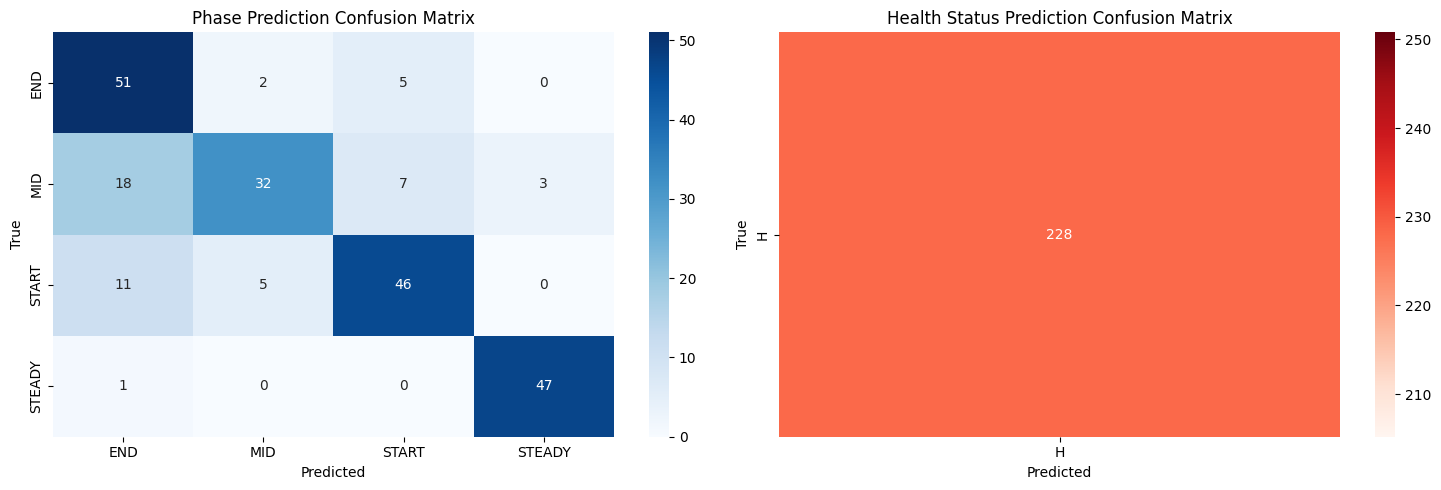


💾 Step 8: Saving results...
✅ Results saved to health_status_results.json
✅ Model saved to health_status_model.h5

📈 Step 9: Visualizing results...


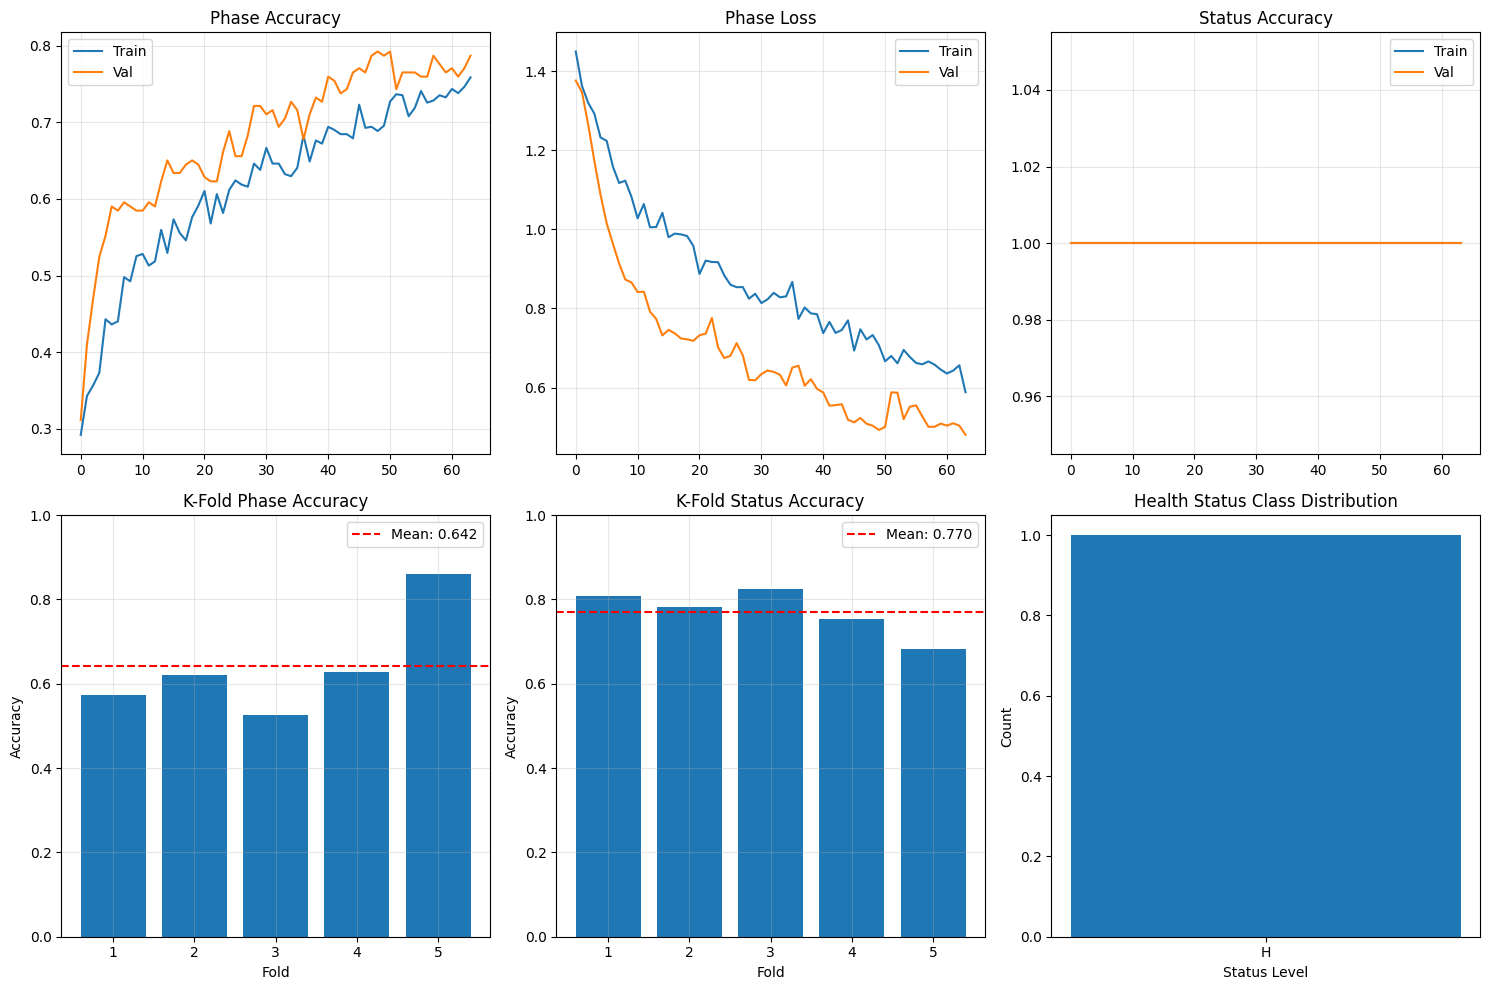


📊 FINAL RESULTS SUMMARY

🎯 Test Performance:
   Phase Accuracy: 47.9%
   Status Accuracy: 77.2%

🔍 K-Fold Validation:
   Phase: 64.2% (±11.5%)
   Status: 77.0% (±5.0%)

📋 Classes Learned:
   Phases: [np.str_('END'), np.str_('MID'), np.str_('START'), np.str_('STEADY')]
   Health Status: [np.str_('H')]

💾 SAVING TO GOOGLE DRIVE
✅ Saved: health_status_model.h5
✅ Saved: phase_encoder.pkl
✅ Saved: status_encoder.pkl
✅ Saved: feature_scaler.pkl
✅ Saved: health_status_results.json
✅ Saved: best_health_status_model.h5

✅ 6 files saved to Google Drive: /content/drive/MyDrive/Health_Status_Model


In [ ]:
# Run the complete system
if __name__ == "__main__":
    print("Starting complete hand movement phase + health status prediction system...")
    pipeline, results = main_simple()

In [ ]:
class DriveSaver:
    """Class to handle saving to Google Drive"""

    def __init__(self, base_path='/content/drive/MyDrive/Health_Status_Model'):
        self.base_path = base_path
        self.setup_drive_folders()

    def setup_drive_folders(self):
        """Create organized folder structure in Google Drive"""
        import shutil

        folders = {
            'base': self.base_path,
            'models': f'{self.base_path}/models',
            'encoders': f'{self.base_path}/encoders',
            'results': f'{self.base_path}/results',
            'visualizations': f'{self.base_path}/visualizations',
            'deployment': f'{self.base_path}/deployment'
        }

        # Create folders
        for folder_name, folder_path in folders.items():
            os.makedirs(folder_path, exist_ok=True)
            print(f"📁 Created: {folder_path}")

        self.folders = folders

    def save_model_artifacts(self, pipeline, predictor=None):
        """Save all model artifacts to Google Drive"""
        import shutil
        from datetime import datetime

        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        version_folder = f'{self.base_path}/version_{timestamp}'
        os.makedirs(version_folder, exist_ok=True)

        print(f"\n💾 Saving model artifacts to: {version_folder}")

        # Files to save
        files_to_save = {
            # Model files
            'health_status_model.h5': f'{version_folder}/health_status_model.h5',
            'best_health_status_model.h5': f'{version_folder}/best_health_status_model.h5',

            # Encoders and scalers
            'phase_encoder.pkl': f'{version_folder}/phase_encoder.pkl',
            'status_encoder.pkl': f'{version_folder}/status_encoder.pkl',
            'feature_scaler.pkl': f'{version_folder}/feature_scaler.pkl',

            # Results and logs
            'health_status_results.json': f'{version_folder}/health_status_results.json',
            'training_log.csv': f'{version_folder}/training_log.csv' if os.path.exists('training_log.csv') else None,

            # Visualizations (save plots)
            'phase_confusion_matrix.png': f'{version_folder}/phase_confusion_matrix.png',
            'status_confusion_matrix.png': f'{version_folder}/status_confusion_matrix.png',
            'training_history.png': f'{version_folder}/training_history.png'
        }

        # Copy files
        saved_files = []
        for source, destination in files_to_save.items():
            if source and os.path.exists(source):
                shutil.copy(source, destination)
                saved_files.append(destination)
                print(f"✅ Saved: {source} → {destination}")

        # Save model summary
        if hasattr(pipeline, 'model'):
            with open(f'{version_folder}/model_summary.txt', 'w') as f:
                pipeline.model.summary(print_fn=lambda x: f.write(x + '\n'))
            saved_files.append(f'{version_folder}/model_summary.txt')

        # Save additional metadata
        metadata = {
            'timestamp': timestamp,
            'phase_classes': list(pipeline.data_loader.phase_encoder.classes_),
            'status_classes': list(pipeline.data_loader.status_encoder.classes_),
            'model_input_shape': str(pipeline.model.input_shape) if hasattr(pipeline, 'model') else 'Unknown',
            'sequence_length': pipeline.sequence_length,
            'step_size': pipeline.step_size
        }

        with open(f'{version_folder}/metadata.json', 'w') as f:
            json.dump(metadata, f, indent=2)
        saved_files.append(f'{version_folder}/metadata.json')

        # Create deployment package
        self.create_deployment_package(version_folder, pipeline)

        print(f"\n📦 Total saved {len(saved_files)} files to Google Drive")

        return version_folder

    def create_deployment_package(self, version_folder, pipeline):
        """Create a complete deployment package"""
        import zipfile

        deployment_files = []

        # Essential files for deployment
        essential_files = [
            'health_status_model.h5',
            'phase_encoder.pkl',
            'status_encoder.pkl',
            'feature_scaler.pkl',
            'metadata.json'
        ]

        # Create deployment directory
        deploy_dir = f'{version_folder}/deployment'
        os.makedirs(deploy_dir, exist_ok=True)

        # Copy essential files to deployment folder
        for file in essential_files:
            source = f'{version_folder}/{file}'
            if os.path.exists(source):
                shutil.copy(source, f'{deploy_dir}/{file}')
                deployment_files.append(f'{deploy_dir}/{file}')

        # Create deployment script
        deployment_script = self._generate_deployment_script(pipeline)
        script_path = f'{deploy_dir}/predictor.py'
        with open(script_path, 'w') as f:
            f.write(deployment_script)
        deployment_files.append(script_path)

        # Create requirements file
        requirements = self._generate_requirements_file()
        req_path = f'{deploy_dir}/requirements.txt'
        with open(req_path, 'w') as f:
            f.write(requirements)
        deployment_files.append(req_path)

        # Create README
        readme = self._generate_readme(pipeline)
        readme_path = f'{deploy_dir}/README.md'
        with open(readme_path, 'w') as f:
            f.write(readme)
        deployment_files.append(readme_path)

        # Create zip file
        zip_path = f'{version_folder}/health_status_predictor.zip'
        with zipfile.ZipFile(zip_path, 'w') as zipf:
            for file in deployment_files:
                if os.path.exists(file):
                    arcname = os.path.basename(file)
                    zipf.write(file, arcname)

        print(f"📦 Created deployment package: {zip_path}")

        return zip_path

    def _generate_deployment_script(self, pipeline):
        """Generate deployment script for the model"""
        script = '''"""
Health Status Predictor - Deployment Script
For predicting movement phase and health status level (H, H1, H2, H3)
"""

import numpy as np
import joblib
import tensorflow as tf
from tensorflow import keras
import json
from datetime import datetime

class HealthStatusPredictorDeployed:
    """Deployed version of health status predictor"""

    def __init__(self, model_path='health_status_model.h5'):
        """
        Initialize the predictor

        Args:
            model_path: Path to the trained model file (.h5)
        """

        print("🔧 Loading Health Status Predictor...")

        # Load model
        self.model = keras.models.load_model(model_path)

        # Load encoders and scaler
        try:
            self.phase_encoder = joblib.load('phase_encoder.pkl')
            self.status_encoder = joblib.load('status_encoder.pkl')
            self.scaler = joblib.load('feature_scaler.pkl')
        except:
            print("⚠️ Warning: Using default encoders and scaler")
            self._create_default_encoders()

        # Load metadata
        with open('metadata.json', 'r') as f:
            self.metadata = json.load(f)

        # Initialize buffer
        self.buffer = []
        self.buffer_size = 20  # Sequence length

        print("✅ Health Status Predictor loaded successfully!")
        print(f"   Phase classes: {self.phase_encoder.classes_}")
        print(f"   Status classes: {self.status_encoder.classes_}")

    def _create_default_encoders(self):
        """Create default encoders if loading fails"""
        from sklearn.preprocessing import LabelEncoder

        self.phase_encoder = LabelEncoder()
        self.phase_encoder.classes_ = np.array(['START', 'MID', 'END', 'STEADY'])

        self.status_encoder = LabelEncoder()
        self.status_encoder.classes_ = np.array(['H', 'H1', 'H2', 'H3'])

        # Create dummy scaler
        from sklearn.preprocessing import StandardScaler
        self.scaler = StandardScaler()

    def prepare_features(self, sensor_data, age=10, gender='M', hand='R', movement_type='FLEXION'):
        """
        Prepare features for prediction

        Args:
            sensor_data: List of sensor readings
            age: Child's age (default: 10)
            gender: 'M' or 'F' (default: 'M')
            hand: 'R' or 'L' (default: 'R')
            movement_type: Type of movement (default: 'FLEXION')

        Returns:
            Prepared features array
        """

        features = list(sensor_data)

        # Add demographic features
        # Age normalization (adjust based on your training data)
        age_normalized = (age - 10) / 5
        features.append(age_normalized)

        # Gender encoding
        gender_encoded = 0 if gender in ['M', 'Male'] else 1
        features.append(gender_encoded)

        # Hand encoding
        hand_encoded = 0 if hand in ['R', 'Right'] else 1
        features.append(hand_encoded)

        # Movement type one-hot encoding
        movement_types = ['FLEXION', 'EXTENSION', 'ADDUCTION', 'ABDUCTION', 'CIRCUMDUCTION', 'STEADY']
        movement_one_hot = [1 if movement_type == m else 0 for m in movement_types]
        features.extend(movement_one_hot)

        # Scale features
        features_scaled = self.scaler.transform([features])

        return features_scaled.flatten()

    def predict(self, sensor_data, age=None, gender=None, hand=None, movement_type=None):
        """
        Make prediction for a single sensor reading

        Args:
            sensor_data: List of sensor readings
            age: Child's age (optional)
            gender: Child's gender (optional)
            hand: Which hand (optional)
            movement_type: Type of movement (optional)

        Returns:
            Dictionary with prediction results
        """

        # Use defaults if not provided
        age = age if age is not None else 10
        gender = gender if gender is not None else 'M'
        hand = hand if hand is not None else 'R'
        movement_type = movement_type if movement_type is not None else 'FLEXION'

        # Prepare features
        prepared_features = self.prepare_features(sensor_data, age, gender, hand, movement_type)

        # Add to buffer
        self.buffer.append(prepared_features)

        if len(self.buffer) > self.buffer_size:
            self.buffer.pop(0)

        # Predict when buffer is full
        if len(self.buffer) == self.buffer_size:
            sequence = np.array(self.buffer)
            sequence = sequence.reshape(1, self.buffer_size, -1)

            # Make prediction
            phase_pred, status_pred = self.model.predict(sequence, verbose=0)

            # Decode predictions
            phase_idx = np.argmax(phase_pred[0])
            status_idx = np.argmax(status_pred[0])

            phase = self.phase_encoder.inverse_transform([phase_idx])[0]
            status = self.status_encoder.inverse_transform([status_idx])[0]

            # Get confidence scores
            phase_confidence = float(np.max(phase_pred[0]))
            status_confidence = float(np.max(status_pred[0]))

            # Generate interpretation
            interpretation = self.interpret_status(status, phase_confidence, status_confidence)

            result = {
                'phase': phase,
                'phase_confidence': phase_confidence,
                'status': status,
                'status_confidence': status_confidence,
                'status_level': status,
                'interpretation': interpretation['description'],
                'overall_confidence': interpretation['confidence'],
                'movement_quality': self.assess_quality(status),
                'recommendation': self.get_recommendation(status),
                'demographics': {
                    'age': age,
                    'gender': gender,
                    'hand': hand,
                    'movement_type': movement_type
                },
                'timestamp': datetime.now().isoformat()
            }

            return result

        return None

    def interpret_status(self, status, phase_conf, status_conf):
        """Interpret health status level"""
        interpretations = {
            'H': "Normal/Healthy movement pattern",
            'H1': "Mild movement irregularity detected",
            'H2': "Moderate movement irregularity detected",
            'H3': "Severe movement irregularity detected"
        }

        confidence_level = "High" if min(phase_conf, status_conf) > 0.8 else \\
                          "Medium" if min(phase_conf, status_conf) > 0.6 else "Low"

        return {
            'description': interpretations.get(status, "Unknown status"),
            'confidence': confidence_level
        }

    def assess_quality(self, status):
        """Assess movement quality"""
        quality_map = {
            'H': {'quality': 'Excellent', 'color': 'green', 'score': 10},
            'H1': {'quality': 'Good', 'color': 'blue', 'score': 7},
            'H2': {'quality': 'Fair', 'color': 'orange', 'score': 4},
            'H3': {'quality': 'Poor', 'color': 'red', 'score': 1}
        }
        return quality_map.get(status, {'quality': 'Unknown', 'color': 'gray', 'score': 0})

    def get_recommendation(self, status):
        """Get recommendation based on status"""
        recommendations = {
            'H': "Continue normal activities. No intervention needed.",
            'H1': "Monitor movement patterns. Consider mild exercises.",
            'H2': "Recommended: Physical therapy consultation.",
            'H3': "Urgent: Medical consultation required."
        }
        return recommendations.get(status, "Consult healthcare professional.")

    def batch_predict(self, sensor_data_list, ages=None, genders=None, hands=None, movement_types=None):
        """
        Make predictions for multiple sensor readings

        Args:
            sensor_data_list: List of sensor data arrays
            ages: List of ages (optional)
            genders: List of genders (optional)
            hands: List of hands (optional)
            movement_types: List of movement types (optional)

        Returns:
            List of prediction results
        """
        results = []

        for i, sensor_data in enumerate(sensor_data_list):
            age = ages[i] if ages and i < len(ages) else None
            gender = genders[i] if genders and i < len(genders) else None
            hand = hands[i] if hands and i < len(hands) else None
            movement_type = movement_types[i] if movement_types and i < len(movement_types) else None

            result = self.predict(sensor_data, age, gender, hand, movement_type)
            if result:
                results.append(result)

        return results

# Example usage
if __name__ == "__main__":
    # Initialize predictor
    predictor = HealthStatusPredictorDeployed()

    # Example sensor data (replace with actual data)
    # Number of features depends on your training data
    example_sensor_data = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    # Make prediction
    result = predictor.predict(
        sensor_data=example_sensor_data,
        age=8,
        gender='M',
        hand='R',
        movement_type='FLEXION'
    )

    if result:
        print(f"\\n📊 Prediction Results:")
        print(f"  Phase: {result['phase']} ({result['phase_confidence']:.1%})")
        print(f"  Status: {result['status']} ({result['status_confidence']:.1%})")
        print(f"  Quality: {result['movement_quality']['quality']}")
        print(f"  Recommendation: {result['recommendation']}")
'''
        return script

    def _generate_requirements_file(self):
        """Generate requirements.txt file"""
        return """tensorflow>=2.10.0
scikit-learn>=1.2.0
pandas>=1.5.0
numpy>=1.23.0
joblib>=1.2.0
"""

    def _generate_readme(self, pipeline):
        """Generate README file"""
        phase_classes = list(pipeline.data_loader.phase_encoder.classes_)
        status_classes = list(pipeline.data_loader.status_encoder.classes_)

        readme = f"""# Hand Movement Health Status Predictor

## Model Information
- **Created**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
- **Purpose**: Predict movement phase and health status level for children's hand movements
- **Input**: Sensor data + Demographics (Age, Gender, Hand)
- **Output**: Phase + Health Status Level

## Model Details
- **Phase Classes**: {', '.join(phase_classes)}
- **Health Status Classes**: {', '.join(status_classes)}
- **Sequence Length**: {pipeline.sequence_length}
- **Step Size**: {pipeline.step_size}

## Files Included
1. `health_status_model.h5` - Trained TensorFlow model
2. `phase_encoder.pkl` - Phase label encoder
3. `status_encoder.pkl` - Status label encoder
4. `feature_scaler.pkl` - Feature scaler
5. `predictor.py` - Deployment script
6. `metadata.json` - Model metadata
7. `requirements.txt` - Required packages

## Quick Start

```python
# Load the predictor
from predictor import HealthStatusPredictorDeployed

# Initialize
predictor = HealthStatusPredictorDeployed('health_status_model.h5')

# Prepare sensor data (adjust size based on your sensors)
sensor_data = [0.1, 0.2, 0.3, ...]  # Your sensor readings

# Make prediction
result = predictor.predict(
    sensor_data=sensor_data,
    age=8,           # Child's age
    gender='M',      # 'M' or 'F'
    hand='R',        # 'R' or 'L'
    movement_type='FLEXION'
)

print(f"Phase: {{result['phase']}}")
print(f"Health Status: {{result['status']}}")
print(f"Recommendation: {{result['recommendation']}}")

SyntaxError: incomplete input (ipython-input-1701033589.py, line 440)